$\textbf{Churn Data: Random Forest}$

We will load in the data on Churn, the 31 covariates and the dependent variable.
Then we will look at how we do Random Forest in Matlab. We will do a Random Forest with 500 trees.



In [1]:
ChurnTab = readtable('NewChurn.xlsx');
VarNames = ChurnTab.Properties.VariableNames;
ChurnData = table2array(ChurnTab);

ChurnData1 = ChurnData;
Target = ChurnData1(:,end);
Y = Target;
x = ChurnData1(:,1:end-1);
ntrees = 500;


Now we will examine the Predictor Importance from the classification trees

In [2]:
Mdl = fitctree(x,Y);
% view(Mdl,'mode','graph');
imp = predictorImportance(Mdl);
VarNames1 = []; for i= 1:5, VarNames1 = [VarNames1 VarNames(i)]; end;
VarNames2 = []; for i= 6:10, VarNames2 = [VarNames2 VarNames(i)]; end;
VarNames3 = []; for i= 11:15, VarNames3 = [VarNames3 VarNames(i)]; end;
VarNames4 = []; for i= 16:20, VarNames4 = [VarNames4 VarNames(i)]; end;
VarNames5 = []; for i= 21:25, VarNames5 = [VarNames5 VarNames(i)]; end;
VarNames6 = []; for i= 26:31, VarNames6 = [VarNames6 VarNames(i)]; end;


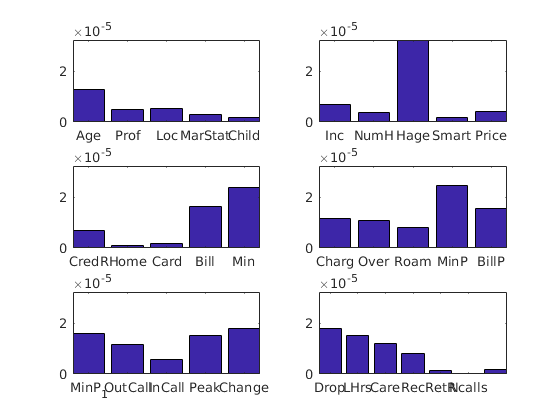

In [127]:
a1 =subplot(321); ...
bar(imp(1:5)); axis([1,5, -1,1]);axis tight;  ...
names1 = VarNames1; ...
set(gca,'xtick',[1:5],'xticklabel',names1);...
a2 =subplot(322); ...
bar(imp(6:10)); axis([1,5, -1,1]);axis tight; ...
names2 = VarNames2; ...
set(gca,'xtick',[1:5],'xticklabel',names2);...
a3 =subplot(323); ...
bar(imp(11:15)); axis([1,5, -1,1]);axis tight;  ...
names3 = VarNames3; ...
set(gca,'xtick',[1:5],'xticklabel',names3);...
a4 =subplot(324); ...
bar(imp(16:20)); axis([1,5, -1,1]);axis tight; ...
names4 = VarNames4; ...
set(gca,'xtick',[1:5],'xticklabel',names4);...
a5 =subplot(325); ...
bar(imp(21:25)); axis([1,5, -1,1]);axis tight; ...
names5 = VarNames5; ...
set(gca,'xtick',[1:5],'xticklabel',names5);...
a6 =subplot(326); ...
bar(imp(25:31)); axis([1,6, -1,1]);axis tight; ...
names6 = VarNames6; ...
set(gca,'xtick',[1:6],'xticklabel',names6);...]
linkaxes([a1, a2,a3,a4,a5,a6], 'y');
saveas(gcf, 'Week9_Importance.eps', 'eps');

We see that handphone age is important,  as well as the number of minutes.

Now we evaluate the predictive accuracy of the random forests.

In [3]:
pred = predict(Mdl,x); % (N,1)
TruePos = mean(pred(Y==1)==1); % ratio of correct positive predictions
TrueNeg = mean(pred(Y==0)==0); % ratio of the correctly predicted negative cases
falsepos = mean(pred(Y==0)==1);% ratio of the negatives that are falsely predicted postive: FP/(FP+TN) 
falseneg = mean(pred(Y==1)==0);% ratio of the positives that are falsely predicted negative: FN/(FN+TP)
Confusion = [TruePos falsepos; falseneg TrueNeg];
Accuracy = mean(pred==Y);

In [4]:
Accuracy


Accuracy =

    0.9235




Lets look at the Confusion Matrix:  the matrix of true and false decisions We see that it is quite accurate for the full sample.

In [5]:
Confusion



Confusion =

    0.9260    0.0790
    0.0740    0.9210




Lets do a repeat set of draws for in an out of sample tests.

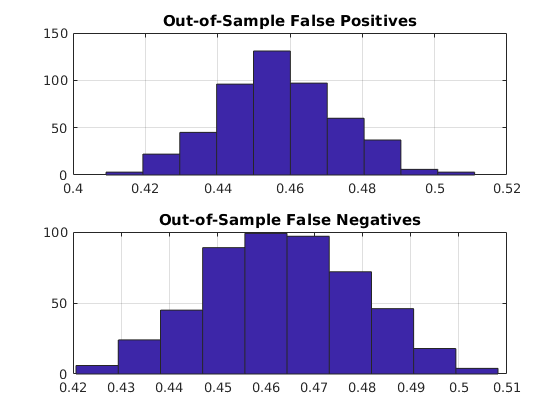

In [131]:
clear yhat1 yhat2 error1 error2 FALSEPOS1 FALSENEG1 test_data;
num_experiments = 500;
K = 7500;
N = length(ChurnData1);
warning off;

for JJ = 1:num_experiments    
    index = randsample(N,K); %(K,)
    train_data = ChurnData1(index,:); %(K,D)
    
    ChurnData11 = ChurnData1; % (N,D)
    ChurnData11(index,:) = []; % (N-K, D)
    test_data = ChurnData11; % (N-K, D) 
    
    y_train =  train_data(:,end);% (K,1)
    X_train =  train_data(:,1:end-1); %(K, D-2)
    X_test = test_data(:,1:end-1);
    y_test = test_data(:,end);

    Mdl = fitctree(X_train,y_train);
    pred = predict(Mdl,X_test);

    
    FALSEPOS1(JJ)  = mean(pred(y_test==0)==1); % ratio of the negatives that are falsely predicted postive: FP/(FP+TN) 
    FALSENEG1(JJ)  = mean(pred(y_test==1)==0);
    
    clear ChurnData11 train_data test_data y_train y_test X_train X_test yhat error error1 error2;
end;


   
 
   
   subplot(211); hist(FALSEPOS1); grid; title('Out-of-Sample False Positives'); ...
       subplot(212); hist(FALSENEG1); grid; title('Out-of-Sample False Negatives'); ...
       saveas(gcf,'RandomForest1.eps','eps');
   
    
save ChurnRFTree2;

We see the out of sample predictive accuracy stats, very different.

$\textbf{Churn Data: Neural Network Prediction}$

Now lets look at the same data with neural net prediction.
We load in the data and then set up a patternnet neural neet with 31 neurons.
We put in options not to show the intermediate training data in windows.

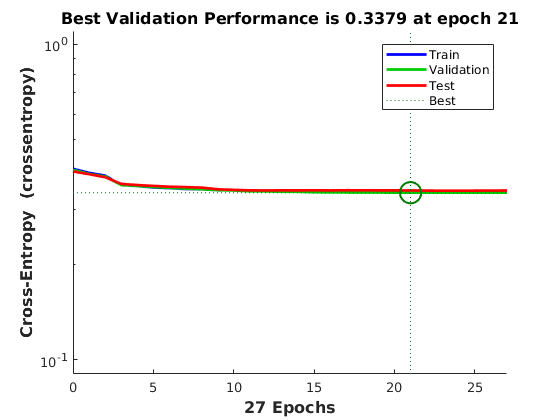

In [166]:
clear all;
ChurnTab = readtable('NewChurn.xlsx');
ChurnData = table2array(ChurnTab);
ChurnData1 = ChurnData;
Target = ChurnData1(:,end);  %(N,1). 1=> postive 0=> negative
t = [Target 1-Target];   % (N,C) Define the dependent binary variable| | [[0 1],[1 0]] is [negative positve]
x = ChurnData1(:,1:end-1); % (N, D-2) Define the covariates 


In [167]:
[net,tr] = train(net,x',t','UseParallel', 'yes','UseGPU','only');
proba = net(x')';%(N,C)
N = length(ChurnData1);

pred = zeros(N,1);
pred(proba(:,1)>0.5)=1; % if first column of proba is 1, that means positive class is predicted
Y = t(:,1);

TruePos = mean(pred(Y==1)==1); % ratio of correct positive predictions
TrueNeg = mean(pred(Y==0)==0); % ratio of the correctly predicted negative cases
falsepos = mean(pred(Y==0)==1);% ratio of the negatives that are falsely predicted postive: FP/(FP+TN) 
falseneg = mean(pred(Y==1)==0);% ratio of the positives that are falsely predicted negative: FN/(FN+TP)
Confusion = [TruePos falsepos; falseneg TrueNeg];

Accuracy = mean(pred==Y);

Starting parallel pool (parpool) using the 'local' profile ...
connected to 4 workers.
Calculation mode: Parallel with GPU Workers
 
Training Pattern Recognition Neural Network with TRAINSCG.
Lab 1: 
  Epoch 0/1000, Time 0.67912, Performance 2.0011/0, Gradient 2.6499/1e-06, Validation Checks 0/6
Lab 1: 
  Epoch 17/1000, Time 1.3891, Performance 0.33976/0, Gradient 0.04153/1e-06, Validation Checks 6/6
  Training with TRAINSCG completed: Validation stop.
   


In [160]:
Accuracy


Accuracy =

    0.5874



We have an almost 60% accuracy rate, not bad.

In [161]:
Confusion


Confusion =

    0.5686    0.3938
    0.4314    0.6062



Lets simulate the model around the median to get the relative importance.

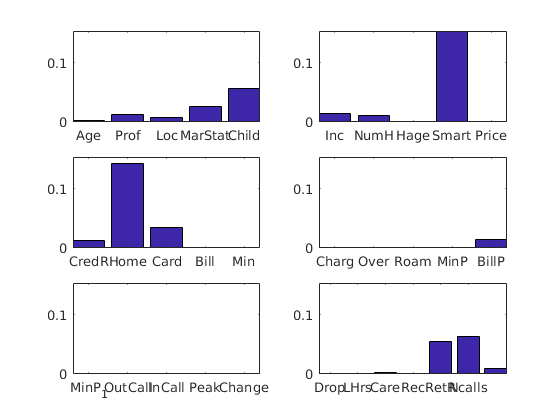

In [168]:
ChurnTab = readtable('NewChurn.xlsx');
VarNames = ChurnTab.Properties.VariableNames;
xmedian = median(x); % (1,D) median value of each column
thatmedian = net(xmedian'); % (1,2)
thatmedian = thatmedian(1); % (1,)
for i = 1:31, xmedian1 = xmedian; xmedian1(i) = xmedian(i) + .00001;
    thatmedian1(i,:) = net(xmedian1');  
    imp(i) = abs((thatmedian1(i,1)-thatmedian)/.00001);
end;

VarNames1 = []; for i= 1:5, VarNames1 = [VarNames1 VarNames(i)]; end;
VarNames2 = []; for i= 6:10, VarNames2 = [VarNames2 VarNames(i)]; end;
VarNames3 = []; for i= 11:15, VarNames3 = [VarNames3 VarNames(i)]; end;
VarNames4 = []; for i= 16:20, VarNames4 = [VarNames4 VarNames(i)]; end;
VarNames5 = []; for i= 21:25, VarNames5 = [VarNames5 VarNames(i)]; end;
VarNames6 = []; for i= 26:31, VarNames6 = [VarNames6 VarNames(i)]; end;

a1 =subplot(321); ...
bar(imp(1:5)); axis([1,5, -1,1]);axis tight;  ...
names1 = VarNames1; ...
set(gca,'xtick',[1:5],'xticklabel',names1);...
a2 =subplot(322); ...
bar(imp(6:10)); axis([1,5, -1,1]);axis tight; ...
names2 = VarNames2; ...
set(gca,'xtick',[1:5],'xticklabel',names2);...
a3 =subplot(323); ...
bar(imp(11:15)); axis([1,5, -1,1]);axis tight;  ...
names3 = VarNames3; ...
set(gca,'xtick',[1:5],'xticklabel',names3);...
a4 =subplot(324); ...
bar(imp(16:20)); axis([1,5, -1,1]);axis tight; ...
names4 = VarNames4; ...
set(gca,'xtick',[1:5],'xticklabel',names4);...
a5 =subplot(325); ...
bar(imp(21:25)); axis([1,5, -1,1]);axis tight; ...
names5 = VarNames5; ...
set(gca,'xtick',[1:5],'xticklabel',names5);...
a6 =subplot(326); ...
bar(imp(25:31)); axis([1,6, -1,1]);axis tight; ...
names6 = VarNames6; ...
set(gca,'xtick',[1:6],'xticklabel',names6);...]
linkaxes([a1, a2,a3,a4,a5,a6], 'y');
saveas(gcf, 'Week9_ImportanceCVsimple.eps', 'eps');

We see that the number of return calls is most important. 
Now let's look at out of sample performance of the network.

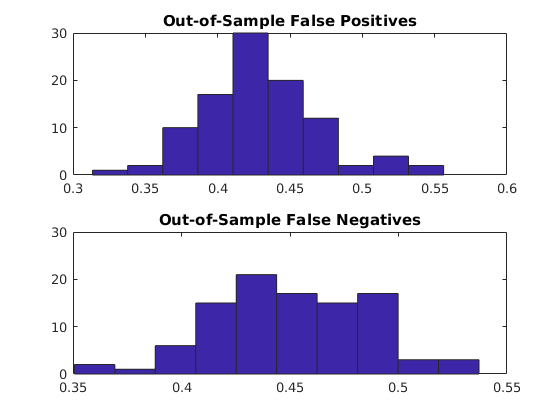

In [163]:
K = 9000;
for J = 1:100,        
    index = randsample(length(ChurnData1),K);
    train_data = ChurnData1(index,:); %(K,D)
    
    ChurnData11 = ChurnData1; % (N,D)
    ChurnData11(index,:) = []; % (N-K, D)
    test_data = ChurnData11; % (N-K, D) 
    
    y_train =  [train_data(:,end) 1-train_data(:,end)];% (K,1)
    X_train =  train_data(:,1:end-1); %(K, D-2)
    X_test = test_data(:,1:end-1);
    y_test = test_data(:,end);
    
    net1 = patternnet([31]);
    net1.trainParam.showWindow = false;
    net1.trainParam.showCommandLine = false;
    
    [net1,tr1] = train(net1, X_train', y_train','UseParallel', 'yes');
    
    proba = net1(X_test')';
    
    pred = zeros(N,1);    
    pred(proba(:,1)>=0.5)=1; % if first column of proba is 1, that means positive class is predicted
    FALSEPOS(J) = mean(pred(y_test==0)==1);% ratio of the negatives that are falsely predicted postive: FP/(FP+TN) 
    FALSENEG(J) = mean(pred(y_test==1)==0);% ratio of the positives that are falsely predicted negative: FN/(FN+TP)

end;
subplot(211); hist(FALSEPOS); title('Out-of-Sample False Positives'); ...
    subplot(212); hist(FALSENEG); title('Out-of-Sample False Negatives');
save ChurnNetwork2;